# GradientBoost 분류 기본코드

Gradient Boosting은 여러 개의 약한 예측 모형들을 결합하여 강력한 예측 모형을 만드는 앙상블 기법 중 하나.

기본 아이디어는 앞서 학습된 모델의 오류를 줄이는 방향으로 새로운 모델을 계속 추가해 나가는 것임

모델을 순차적으로 학습시키며, 각 모델은 이전 모델의 잔차를 줄이는 방향으로 학습한다.

이때, 각 단계에서 오류를 줄이기 위해 그래디언트 하강법을 사용하여 손실 함수(loss function)의 그래디언트(경사)를 계산하고, 이를 이용해 모델을 업데이트한다.

즉, 잔차를 이용하여 이전 모형의 약점을 보완하는 새로운 모형을 순차적으로 적합한 뒤 이들을 선형 결합하여 얻어진 모형을 생성한다.


| 특징 | 내용                                                                                                                          |
| ---- | ----------------------------------------------------------------------------------------------------------------------------- |
| 장점 | 1. 구현이 쉽다<br/>2. 정확도가 좋다.<br/>3.유연하다(의사결정나무 이외에 다른 알고리즘 적용 가능. 여러가지 손실함수 적용 가능) |
| 단점 | 1. 과적합 발생 가능성 큼<br/>2. 메모리 사용량이 큼<br/>3. 해석이 어려움                                                       |

GBM은 과적합에도 강한 뛰어난 예측 성능을 가진 알고리즘이지만 
드웨어 요구사항이 다른 알고리즘에 비해 높기 때문에 메모리 소비가 크고, 수행 시간이 오래 걸린다는 단점이 있어서 실제로 잘 사용되지는 않는다.

이 알고리즘이 처음 소개되고 이를 기반으로한 많은 알고리즘이 나왔으며 최근 가장 각광 받고 있는 ML 패키지는 `XGBoost`와 `LightGBM`, `CatBoost`이다.

## #01. 준비작업

### [1] 패키지 가져오기


In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# GradientBoost
from sklearn.ensemble import GradientBoostingClassifier

## #02. 데이터 가져오기


In [2]:
origin = my_read_excel(
    "https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 전처리

1. `0` 값을 포함해서는 안되는 변수에 대해 평균으로 대체
2. 훈련/검증 데이터 분할 및 데이터 표준화

In [3]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 훈련/검증 데이터 분할 및 데이터 표준화
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #03. GradientBoost

### [1] 기본 모형 만들기

| 하이퍼 파라미터       | 기본값       | 설명                                                  | 추천사항                                   |
|-------------------|-----------|-----------------------------------------------------|-----------------------------------------|
| `loss`            | `log_loss`| 손실 함수. `log_loss`는 로지스틱 회귀와 유사.                | `exponential`는 AdaBoost와 유사  |
| **`learning_rate`**   | `0.1`     | 학습률. 각 트리의 기여도 조절.                                  | 낮은 값 + 높은 `n_estimators` 조합 권장.        |
| **`n_estimators`**    | `100`     | 부스팅 단계 수. 트리의 개수.                                 | 너무 높으면 과적합. 적절한 값 탐색 필요.            |
| **`subsample`**       | `1.0`     | 훈련에 사용하는 샘플 비율(`0~1 사이`). 스태깅 사용 시.                       | `1.0` 미만 값은 분산 감소 효과 있으나, 과적합 위험 감소. |
| **`criterion`**       | `friedman_mse` | 트리 품질 측정 기준. `friedman_mse`는 프리드먼의 평균 제곱 오차. | 기본값 권장.                             |
| `min_samples_split` | `2`       | 노드 분할 위한 최소 샘플 수.                                 | 과적합 방지를 위해 조정 가능.                      |
| `min_samples_leaf` | `1`       | 리프 노드가 되기 위한 최소 샘플 수.                            | 과적합 제어에 유용.                               |
| `max_depth`       | `3`       | 개별 회귀 추정기의 최대 깊이.                               | 깊이 크면 과적합 위험. 적절한 값 설정 중요.             |
| `max_features`    | `None`    | `‘sqrt’`, `‘log2’` 최적 분할을 위해 고려할 최대 특성 수.                         | 특성 수의 제곱근 사용 권장. 과적합 방지.               |
| `random_state`    | `None`    | 난수 시드.                                            | 결과 재현을 위해 사용.                          |


+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.916938 |     0.798701 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |        0.925 |     0.666667 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.837104 |     0.680851 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0381679 |     0.149533 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.961832 |     0.850467 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |      0.87886 |     0.673684 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.976466 |      0.85007 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--------------

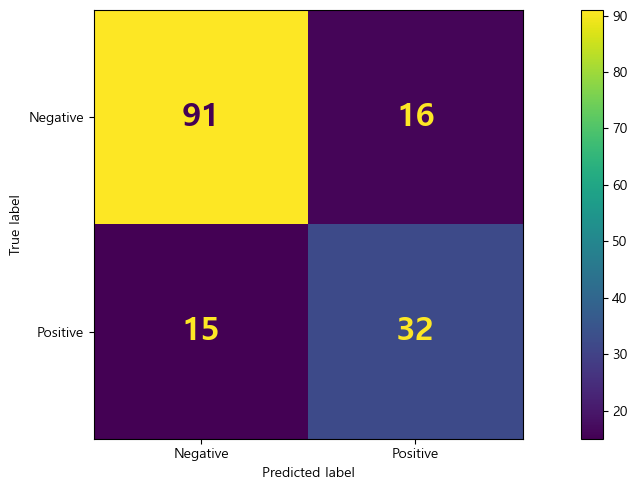

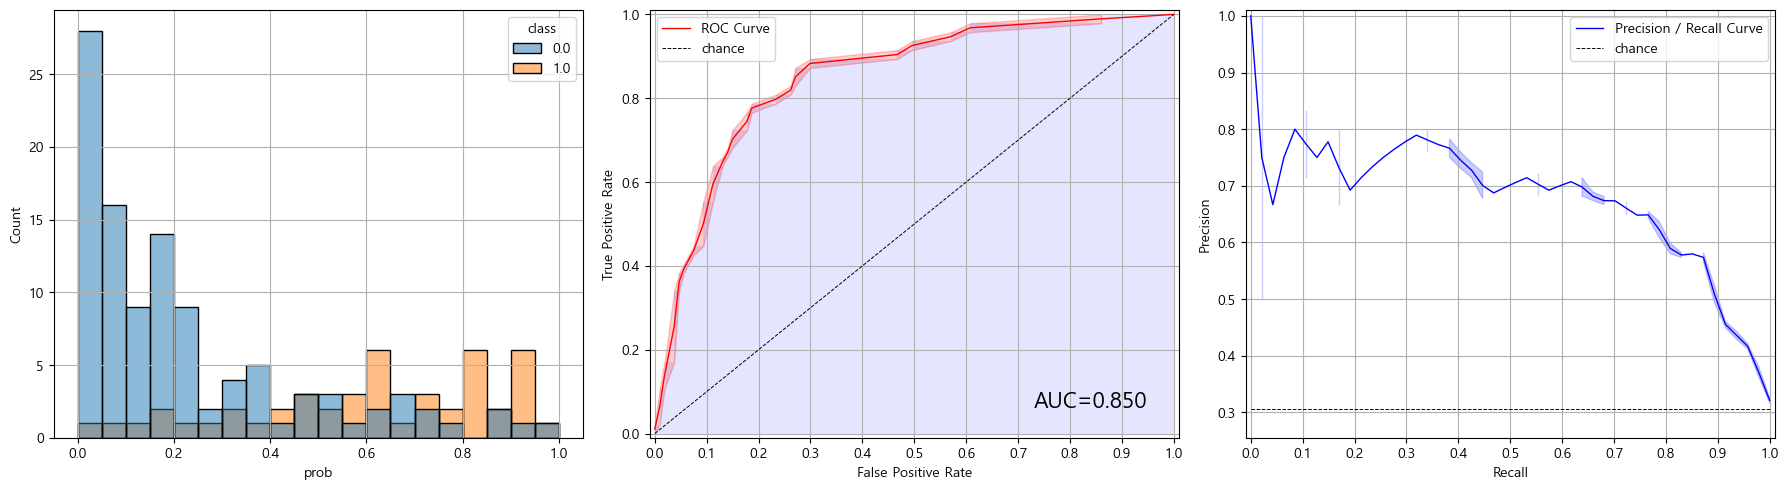

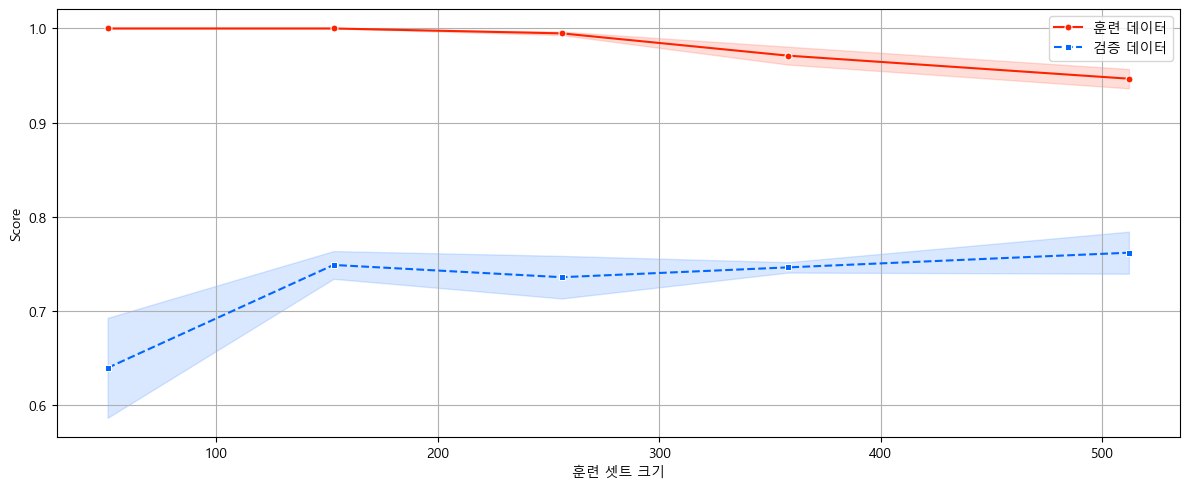

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+
CPU times: total: 1.81 s
Wall time: 4.15 s


In [4]:
%%time

gb = GradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        n_estimators=100,
        subsample=1,
        random_state=get_random_state())

gb.fit(X=x_train, y=y_train)

my_classification_result(estimator=gb, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

my_classification_report(estimator=gb, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

## #04. 모듈화 기능 확인

[교차검증 TOP5]
+----+-------------+----------------+-----------------+-------------------+
|    |   subsample |   n_estimators |   learning_rate |   mean_test_score |
|----+-------------+----------------+-----------------+-------------------|
|  0 |         0.5 |             50 |             0.1 |           0.75735 |
|  1 |           1 |             50 |             0.1 |          0.754098 |
|  2 |         0.7 |            100 |             0.1 |          0.750846 |
|  3 |           1 |             10 |             0.1 |          0.747541 |
|  4 |           1 |             20 |             0.1 |          0.736146 |
+----+-------------+----------------+-----------------+-------------------+

[Best Params]
{'subsample': 0.5, 'n_estimators': 50, 'learning_rate': 0.1}

+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|--------------

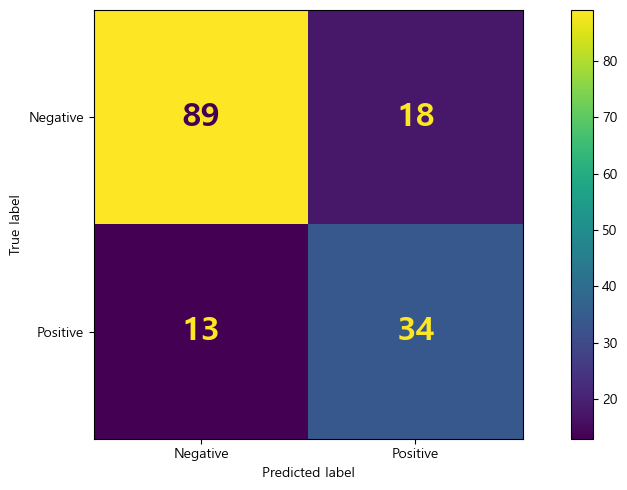

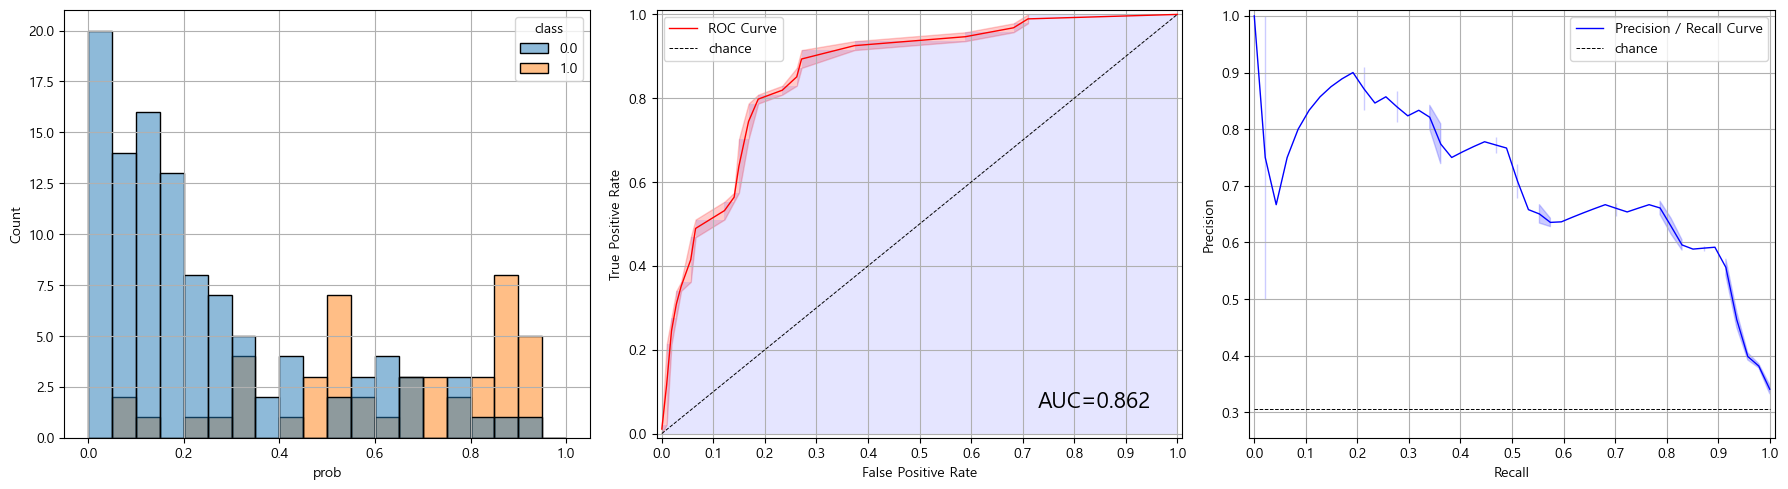

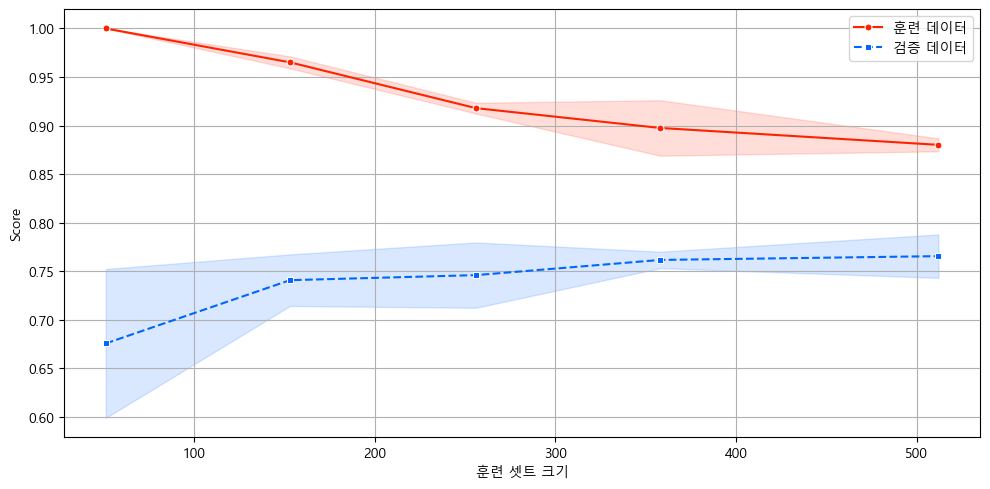

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 1.64872 |
|  1 |       3 | Outcome    | SkinThickness            |  1.5504 |
|  2 |       0 | Outcome    | Pregnancies              | 1.53706 |
|  3 |       5 | Outcome    | BMI                      | 1.52814 |
|  4 |       1 | Outcome    | Glucose                  | 1.33393 |
|  5 |       4 | Outcome    | Insulin                  | 1.28711 |
|  6 |       2 | Outcome    | BloodPressure            | 1.25589 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
+----+---------+------------+--------------------------+---------+


GradientBoostingClassifier(n_estimators=50, random_state=0, subsample=0.5,
                           verbose=False)

In [5]:
my_gbm_classification(x_train, y_train, x_test, y_test)